# Overview

In [1]:
import sys
import os
import math
from typing import Dict

import pandas as pd
import matplotlib.pyplot as plt

In [2]:
sys.path.append(os.path.abspath(".."))
from ners.core.config import setup_config
from ners.core.utils.data_loader import DataLoader
from ners.core.utils.region_mapper import RegionMapper

In [3]:
config = setup_config()
loader = DataLoader(config)

2025-10-05 22:55:20,981 - root - INFO - Ensured all required directories exist
2025-10-05 22:55:20,987 - root - INFO - Loaded configuration: drc_names_pipeline v1.0.0
2025-10-05 22:55:20,995 - root - INFO - Environment: development
2025-10-05 22:55:21,002 - root - INFO - Config file: config/pipeline.development.yaml


In [4]:
df = loader.load_csv_complete(config.paths.data_dir / "names.csv")

2025-10-05 22:55:21,044 - root - INFO - Reading /Users/bernard-ng/dev/community/analysis/drc-ners-nlp/data/dataset/names.csv with encoding: utf-8
2025-10-05 22:57:35,223 - root - INFO - Successfully read /Users/bernard-ng/dev/community/analysis/drc-ners-nlp/data/dataset/names.csv with encoding: utf-8
2025-10-05 22:57:35,237 - root - INFO - Concatenating 81 optimized chunks


## Quantitative

In [5]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
id,8069950.0,16.231662,20.139369,0.0,4.0,10.0,21.0,939.0
percentage,8069950.0,56.188421,5.403735,10.0,52.0,55.0,59.0,96.0
year,8069950.0,2017.599677,4.371243,2008.0,2015.0,2019.0,2021.0,2023.0
line,8069950.0,118021.649797,195762.213691,4.0,6957.0,19192.0,117146.0,826262.0


## Regions

In [6]:
table = (
    df["region"]
    .value_counts()  # counts by frequency
    .rename_axis("Value")  # name the index
    .reset_index(name="Count")  # make it a DataFrame
    .sort_values("Value")  # sort alphabetically
    .reset_index(drop=True)  # clean row index
)

table

,Value,Count
0,bandundu,165090
1,bandundu-1,37755
2,bandundu-2,75006
3,bandundu-3,27907
4,bas-congo,45604
...,...,...
120,tshopo-1,49612
121,tshopo-2,23624
122,tshuapa,13717
123,tshuapa-1,8206


## Subregions by Parent Region

In [7]:
def build_subregion_tables(
    series: pd.Series, mapper: RegionMapper
) -> Dict[str, pd.DataFrame]:
    """
    Returns { PARENT -> DataFrame[subregion, count] }.
    Parent is the mapped province produced by RegionMapper.map().
    """
    s = series.astype(str).str.strip().str.lower()
    parents = mapper.map(s)
    df_regions = pd.DataFrame({"subregion": s, "parent": parents})
    counts = (
        df_regions.groupby(["parent", "subregion"], as_index=False)
        .size()
        .rename(columns={"size": "count"})
    )

    out: Dict[str, pd.DataFrame] = {}
    for parent, g in counts.groupby("parent"):
        g = g.sort_values(["count", "subregion"], ascending=[False, True])
        out[parent] = g.reset_index(drop=True)
    return out


def plot_all_parents_grid(series: pd.Series, mapper: RegionMapper, per_row: int = 4):
    """
    Plot horizontal bar charts of subregion counts for every parent in
    RegionMapper.get_provinces(), arranged as a grid with `per_row` columns.
    """

    def truncate_label(l: str, max_len: int = 15) -> str:
        return l if len(l) <= max_len else l[: max_len - 3] + "..."

    # Build subregion tables once
    tables = build_subregion_tables(series, mapper)

    # Respect the explicit list of parents from RegionMapper
    parents = [
        p.upper() for p in mapper.get_provinces()
    ]  # mapper.get_provinces() are lowercase
    n = len(parents)
    rows = math.ceil(n / per_row)

    # Make figure size scale with grid size
    fig_w = 6 * per_row
    fig_h = max(4.8 * rows, 3.5)  # minimum height
    fig, axes = plt.subplots(rows, per_row, figsize=(fig_w, fig_h))
    if rows == 1 and per_row == 1:
        axes = [[axes]]
    elif rows == 1:
        axes = [axes]
    elif per_row == 1:
        axes = [[ax] for ax in axes]

    # Draw each parent's subplot
    for idx, parent in enumerate(parents):
        r = idx // per_row
        c = idx % per_row
        ax = axes[r][c]

        dfp = tables.get(parent)
        if dfp is None or dfp.empty:
            ax.set_title(parent)
            ax.text(0.5, 0.5, "No data", ha="center", va="center")
            ax.set_axis_off()
            continue

        labels = [truncate_label(lbl, 15) for lbl in dfp["subregion"]]

        # Horizontal bar chart: y=subregion, x=count (sorted by count desc already)
        ax.barh(labels, dfp["count"])
        ax.set_title(parent)
        ax.set_xlabel("Count")
        ax.set_ylabel("Subregion")
        ax.invert_yaxis()  # largest at top
        # Improve readability with many labels
        for label in ax.get_yticklabels():
            label.set_fontsize(8)

    # Turn off any leftover empty axes
    total_axes = rows * per_row
    for j in range(n, total_axes):
        r = j // per_row
        c = j % per_row
        axes[r][c].set_axis_off()

    plt.tight_layout()
    plt.show()

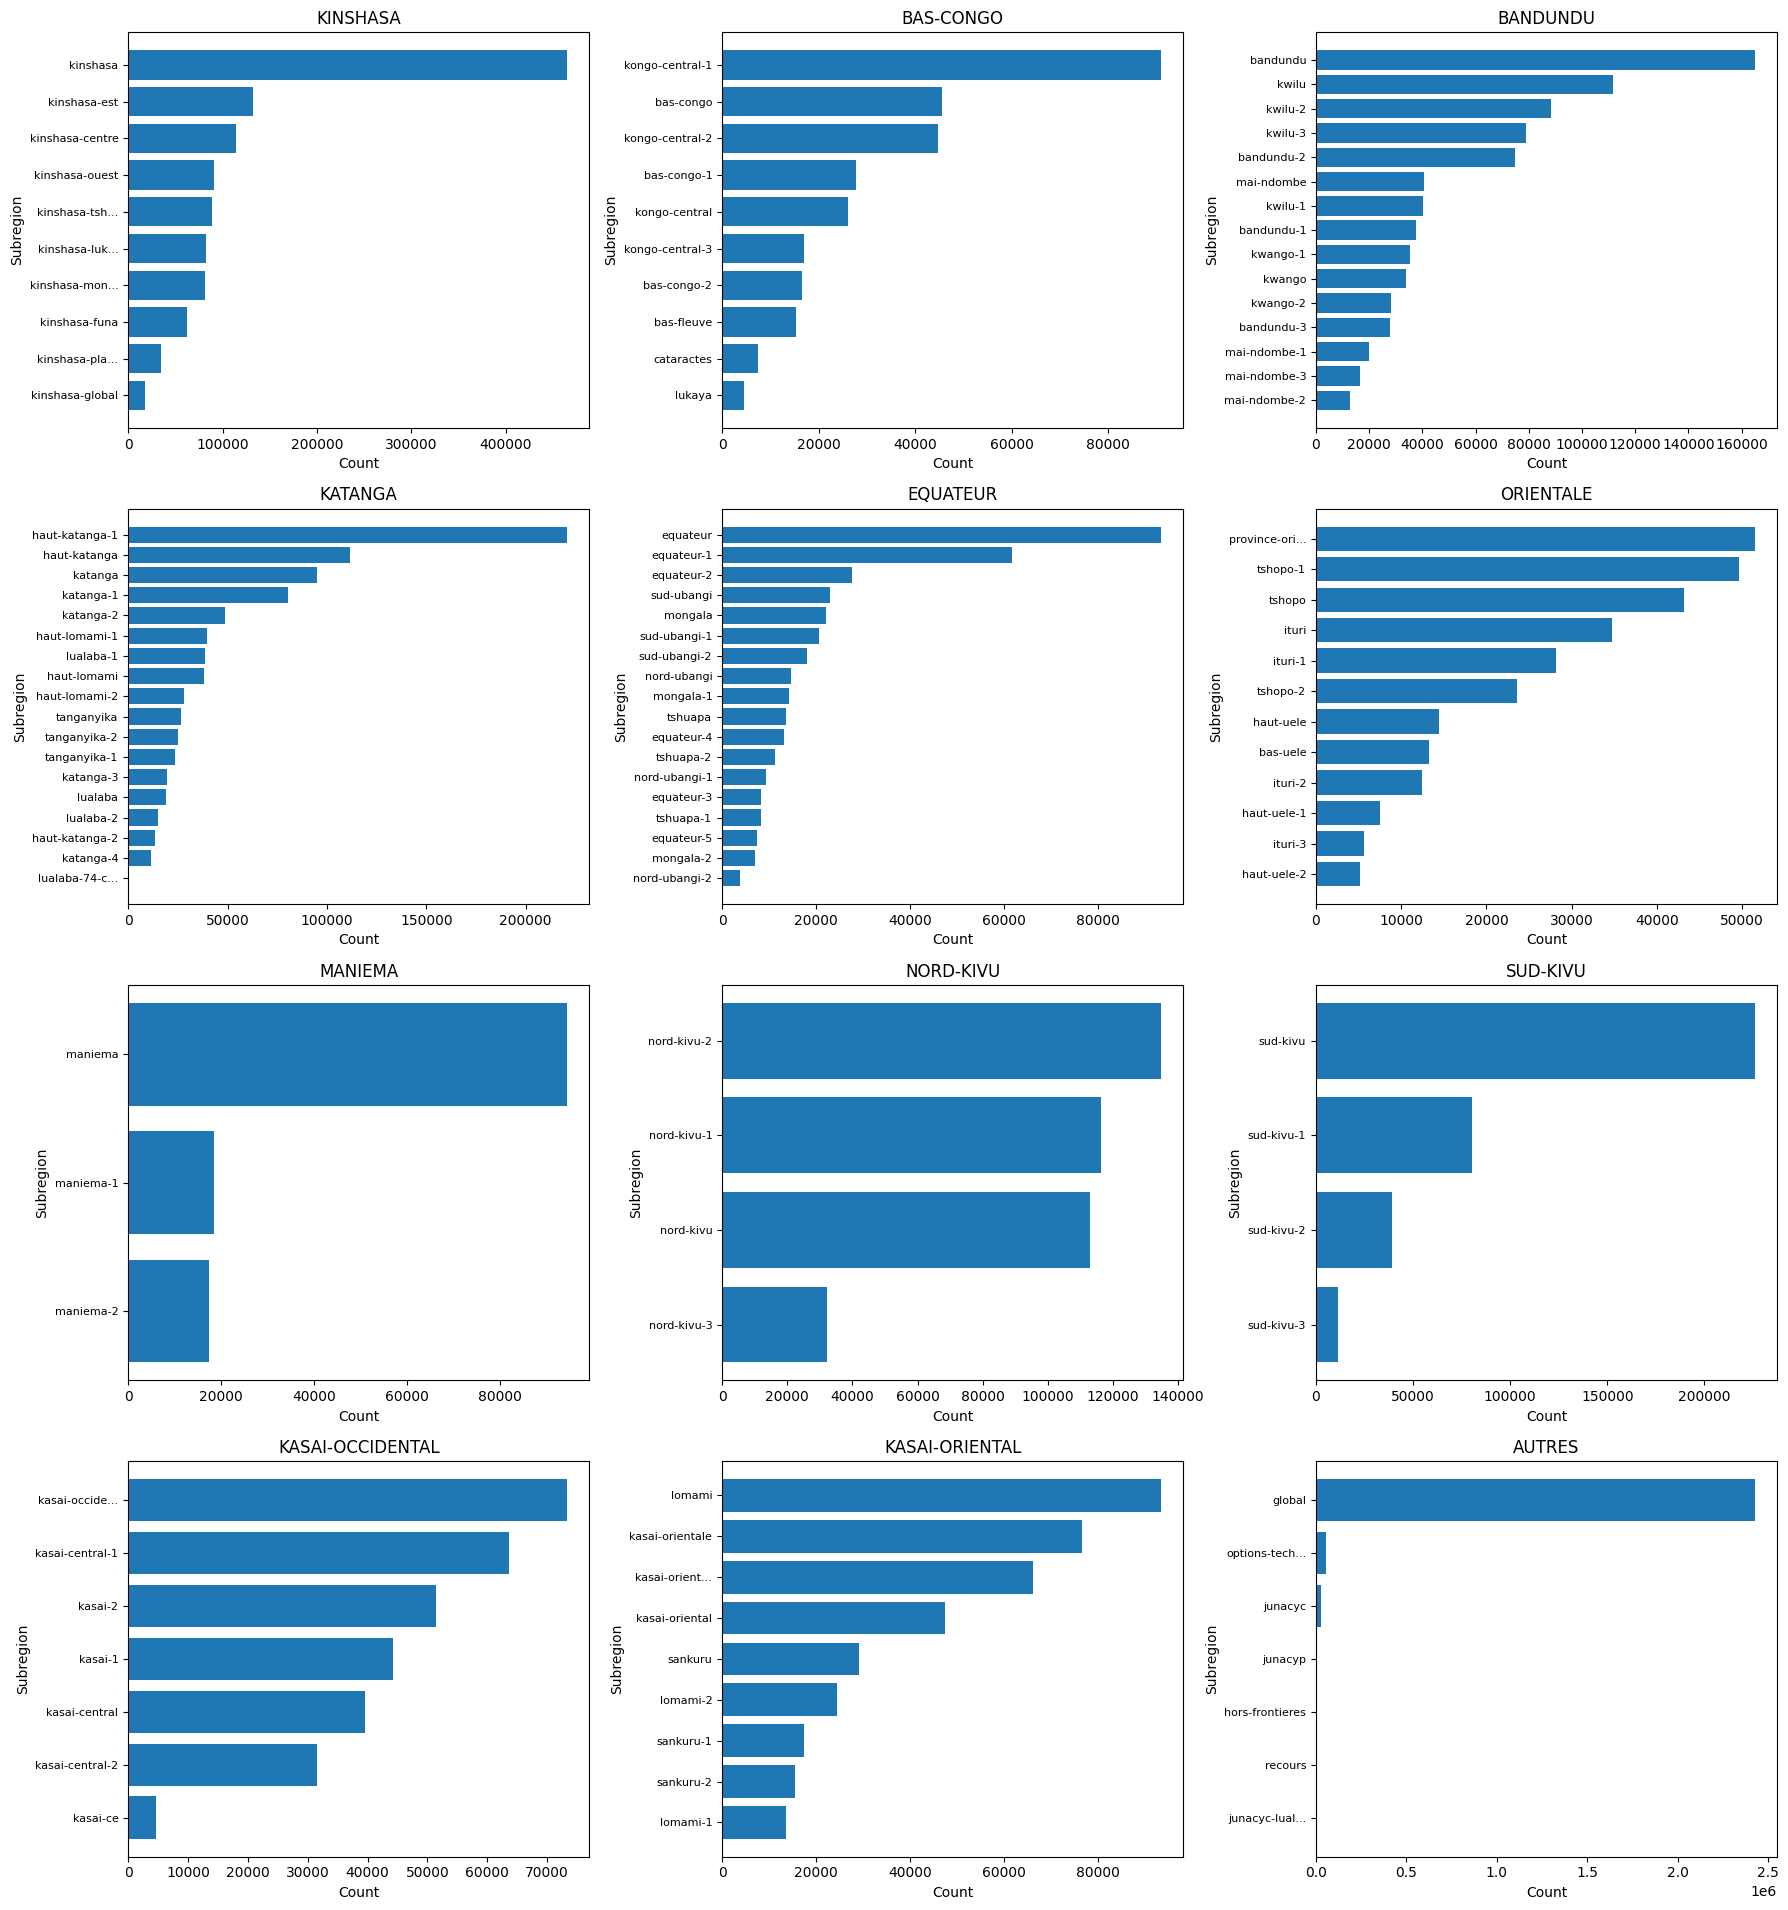

In [8]:
plot_all_parents_grid(df["region"], RegionMapper(), per_row=3)

In [9]:
df["province"] = RegionMapper().map(df["region"])

In [10]:
df.columns

Index(['id', 'name', 'sex', 'percentage', 'year', 'region', 'filename', 'line',
       'province'],
      dtype='object')

In [12]:
import numpy as np
import pandas as pd
import networkx as nx
from matplotlib.patches import Circle


def _province_palette(provinces):
    """Map each province to a color using matplotlib's default cycle."""
    colors = (
        plt.rcParams["axes.prop_cycle"]
        .by_key()
        .get("color", ["C0", "C1", "C2", "C3", "C4", "C5", "C6", "C7", "C8", "C9"])
    )
    return {p: colors[i % len(colors)] for i, p in enumerate(sorted(provinces))}


def plot_region_clusters_by_province(
    df: pd.DataFrame,
    year_col: str = "year",
    region_col: str = "region",
    province_col: str = "province",
    figsize=(14, 9),
    node_size_min: float = 30,
    node_size_max: float = 600,
    province_padding: float = 1.6,  # spacing between province cluster centers
    hull_alpha: float = 0.08,  # alpha for province “enclosing” circles
    label_regions: bool = True,
    label_max_chars: int = 18,
    random_seed: int = 42,
):
    """
    Visualize how regions cluster inside provinces.
    - One node per region, grouped by its province.
    - Node size ~ count of (province, region) across all years.
    - Node color = province; legend shows province colors.
    """
    # --- Prepare aggregated weights per (province, region) ---
    dfx = df[[year_col, region_col, province_col]].dropna().copy()
    dfx[province_col] = dfx[province_col].astype(str).str.strip()
    dfx[region_col] = dfx[region_col].astype(str).str.strip()
    agg = (
        dfx.groupby([province_col, region_col], as_index=False)
        .size()
        .rename(columns={"size": "count"})
    )

    if agg.empty:
        raise ValueError("No data after cleaning; check inputs.")

    provinces = sorted(agg[province_col].unique())
    color_map = _province_palette(provinces)

    # Scale node sizes from counts
    cmin, cmax = agg["count"].min(), agg["count"].max()
    if cmax == cmin:
        sizes = np.full(len(agg), (node_size_min + node_size_max) / 2.0)
    else:
        sizes = node_size_min + (agg["count"] - cmin) * (
            node_size_max - node_size_min
        ) / (cmax - cmin)
    agg["_size"] = sizes

    # --- Lay out provinces on a grid; do a small spring layout per province around its center ---
    rng = np.random.default_rng(random_seed)

    # Choose grid dimensions close to square
    nP = len(provinces)
    ncols = math.ceil(math.sqrt(nP))
    math.ceil(nP / ncols)

    # Province centers on grid
    centers = {}
    for idx, p in enumerate(provinces):
        r, c = divmod(idx, ncols)
        centers[p] = (
            c * province_padding,
            -r * province_padding,
        )  # y negative to go "down"

    # Build positions
    pos = {}  # (province, region) -> (x,y)
    hull_radii = {}  # province -> radius used for background circle

    for p in provinces:
        sub = agg[agg[province_col] == p].reset_index(drop=True)
        center = np.array(centers[p], dtype=float)

        # Make a tiny graph with one hub (province) pulling region nodes inward
        G = nx.Graph()
        hub = f"__hub__::{p}"
        G.add_node(hub)

        for i, row in sub.iterrows():
            node = (p, row[region_col])
            G.add_node(node)
            # connect to hub with weight inversely related to count (heavier count -> shorter spring)
            # spring_layout interprets 'weight' so larger weight pulls nodes closer
            w = float(row["count"])
            G.add_edge(hub, node, weight=max(1.0, w))

        # Initial positions: jitter around center
        init_pos = {hub: center}
        for node in G.nodes:
            if node == hub:
                continue
            init_pos[node] = center + rng.normal(scale=0.15, size=2)

        # Small local layout
        # Note: spring_layout is deterministic with seed
        ploc = nx.spring_layout(
            G,
            k=0.25,
            iterations=60,
            weight="weight",
            seed=random_seed,
            pos=init_pos,
            fixed=[hub],
        )

        # Save region node positions; track cluster radius
        pts = []
        for node in G.nodes:
            if node == hub:
                continue
            pos[node] = ploc[node]
            pts.append(ploc[node])

        if pts:
            pts = np.vstack(pts)
            # radius ~ 1.2 * std distance to center, with minimum
            d = np.linalg.norm(pts - center, axis=1)
            hull_radii[p] = max(0.35, 1.2 * (np.median(d) if len(d) > 4 else d.mean()))
        else:
            hull_radii[p] = 0.4

    # --- Plot ---
    fig, ax = plt.subplots(figsize=figsize)

    # Province hulls (soft circles)
    for p in provinces:
        cx, cy = centers[p]
        circ = Circle(
            (cx, cy),
            radius=hull_radii[p],
            facecolor=color_map[p],
            edgecolor="none",
            alpha=hull_alpha,
        )
        ax.add_patch(circ)

    # Region nodes
    handles = []
    labels = []
    for p in provinces:
        sub = agg[agg[province_col] == p]
        xs, ys, ss = [], [], []
        for _, row in sub.iterrows():
            node = (p, row[region_col])
            x, y = pos[node]
            xs.append(x)
            ys.append(y)
            ss.append(row["_size"])
        sc = ax.scatter(
            xs, ys, s=ss, alpha=0.85, edgecolors="none", label=p, color=color_map[p]
        )
        handles.append(sc)
        labels.append(p)

        # Labels (optional)
        if label_regions:
            for _, row in sub.iterrows():
                node = (p, row[region_col])
                x, y = pos[node]
                name = row[region_col]
                if len(name) > label_max_chars:
                    name = name[: label_max_chars - 1] + "…"
                ax.text(x, y, name, fontsize=7, ha="center", va="center")

    # Axes aesthetics
    ax.set_aspect("equal", adjustable="datalim")
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.set_title(
        "Regions clustered within Provinces (node size = frequency across years)"
    )

    # Province legend
    ncols = 4 if len(labels) > 10 else 2
    ax.legend(
        handles,
        labels,
        title="Province",
        loc="upper right",
        bbox_to_anchor=(1.0, 1.0),
        ncol=ncols,
    )

    # Expand limits to fit hulls nicely
    xs, ys = zip(*centers.values())
    ax.set_xlim(min(xs) - province_padding, max(xs) + province_padding)
    ax.set_ylim(min(ys) - province_padding, max(ys) + province_padding)

    plt.tight_layout()
    plt.show()

In [15]:
import pandas as pd
import matplotlib.patheffects as path_effects


def _province_palette(provinces):
    colors = (
        plt.rcParams["axes.prop_cycle"]
        .by_key()
        .get("color", ["C0", "C1", "C2", "C3", "C4", "C5", "C6", "C7", "C8", "C9"])
    )
    return {p: colors[i % len(colors)] for i, p in enumerate(sorted(provinces))}


def _separate_points(points, radii, iters=60, step=0.02):
    """
    Simple collision-avoidance: iteratively push circles (points with radii)
    apart until overlaps are (mostly) gone.
    points: (N,2) array; radii: (N,) array in same coordinate units
    """
    P = points.copy().astype(float)
    R = radii.astype(float)
    N = len(P)
    for _ in range(iters):
        moved = 0.0
        for i in range(N):
            for j in range(i + 1, N):
                d = P[j] - P[i]
                dist = np.hypot(d[0], d[1])
                min_d = R[i] + R[j]
                if dist < 1e-6:
                    # tiny random kick to avoid division by zero
                    d = np.random.default_rng().normal(scale=1e-3, size=2)
                    dist = np.hypot(d[0], d[1])
                if dist < min_d:
                    # push each point away from the other
                    push = (min_d - dist) / 2.0
                    delta = (d / dist) * (push + 1e-3)
                    P[i] -= delta * step
                    P[j] += delta * step
                    moved += push
        if moved < 1e-3:
            break
    return P


def plot_region_clusters_by_province_readable(
    df: pd.DataFrame,
    year_col: str = "year",
    region_col: str = "region",
    province_col: str = "province",
    figsize=(18, 11),
    node_size_min: float = 60,
    node_size_max: float = 1100,
    label_top_k: int = 12,  # show labels only for the top-K regions per province
    min_count_for_dot: int = 1,  # drop ultra-rare regions if needed (e.g., 2 or 3)
    base_padding: float = 1.6,  # base spacing; will be auto-scaled per province
    hull_alpha: float = 0.10,
    random_seed: int = 42,
):
    """
    Readable 'regions clustered within provinces' visualization.

    - Dots: one per (province, region), size ~ total count across years.
    - Color: province.
    - Labels: top-K per province only, with white halo for contrast.
    - Collision-avoidance keeps dots separate and text readable.
    - Province spacing grows with number of regions in the province.
    """
    # --- aggregate ---
    dfx = df[[year_col, region_col, province_col]].dropna().copy()
    dfx[province_col] = dfx[province_col].astype(str).str.strip()
    dfx[region_col] = dfx[region_col].astype(str).str.strip()

    agg = (
        dfx.groupby([province_col, region_col], as_index=False)
        .size()
        .rename(columns={"size": "count"})
    )
    if min_count_for_dot > 1:
        agg = agg.loc[agg["count"] >= min_count_for_dot]

    if agg.empty:
        raise ValueError("No data after filtering; relax thresholds.")

    provinces = sorted(agg[province_col].unique())
    color_map = _province_palette(provinces)

    # sizes scaled per global min/max
    cmin, cmax = agg["count"].min(), agg["count"].max()
    if cmax == cmin:
        agg["_size"] = (node_size_min + node_size_max) / 2.0
    else:
        agg["_size"] = node_size_min + (agg["count"] - cmin) * (
            node_size_max - node_size_min
        ) / (cmax - cmin)

    # radius used for collision (approximate pixel-independent unit)
    # convert marker size (points^2) into a rough radius in data coords by picking a scale;
    # since our layout is arbitrary units, a simple proportional mapping works:
    agg["_radius"] = np.sqrt(agg["_size"]) * 0.02

    # --- province centers on grid with adaptive spacing ---
    # provinces with many regions need more room
    counts_per_prov = (
        agg.groupby(province_col)["region"].count().reindex(provinces, fill_value=1)
    )
    scale_per_prov = (
        (counts_per_prov / counts_per_prov.median()).clip(0.8, 2.0).to_dict()
    )

    nP = len(provinces)
    ncols = math.ceil(math.sqrt(nP))
    math.ceil(nP / ncols)

    centers = {}
    for idx, p in enumerate(provinces):
        r, c = divmod(idx, ncols)
        pad = base_padding * scale_per_prov[p]
        centers[p] = (c * pad, -r * pad)

    rng = np.random.default_rng(random_seed)
    pos = {}
    hull_radii = {}

    # --- per-province local layout + collision-avoidance ---
    for p in provinces:
        sub = agg[agg[province_col] == p].reset_index(drop=True)
        center = np.array(centers[p], dtype=float)

        # start with small random jitter around center
        pts = center + rng.normal(scale=0.1, size=(len(sub), 2))
        pts = _separate_points(pts, sub["_radius"].to_numpy(), iters=80, step=0.8)

        # optional spring-like pull to center to keep bunch tight
        pts = center + 0.85 * (pts - center)

        for (x, y), (_, row) in zip(pts, sub.iterrows()):
            pos[(p, row[region_col])] = (float(x), float(y))

        # cluster hull radius based on spread
        d = np.linalg.norm(pts - center, axis=1)
        hull_radii[p] = max(0.35, 1.25 * (np.median(d) if len(d) > 4 else d.mean()))

    # --- draw ---
    fig, ax = plt.subplots(figsize=figsize)

    # soft province circles
    for p in provinces:
        cx, cy = centers[p]
        circ = Circle(
            (cx, cy),
            radius=hull_radii[p],
            facecolor=color_map[p],
            edgecolor="none",
            alpha=hull_alpha,
        )
        ax.add_patch(circ)

    # dots + labels (top-K)
    handles, labels = [], []
    for p in provinces:
        sub = (
            agg[agg[province_col] == p]
            .sort_values("count", ascending=False)
            .reset_index(drop=True)
        )
        xs, ys, ss = [], [], []
        for _, row in sub.iterrows():
            x, y = pos[(p, row[region_col])]
            xs.append(x)
            ys.append(y)
            ss.append(row["_size"])
        sc = ax.scatter(
            xs, ys, s=ss, alpha=0.9, edgecolors="none", label=p, color=color_map[p]
        )
        handles.append(sc)
        labels.append(p)

        # labels only for top-K
        top = sub.head(label_top_k)
        for _, row in top.iterrows():
            x, y = pos[(p, row[region_col])]
            txt = row[region_col]
            if len(txt) > 18:
                txt = txt[:17] + "…"
            t = ax.text(x, y, txt, fontsize=8, ha="center", va="center", color="black")
            # white halo for contrast
            t.set_path_effects(
                [
                    path_effects.Stroke(linewidth=2.5, foreground="white"),
                    path_effects.Normal(),
                ]
            )

    # legend, axes, limits
    ax.legend(handles, labels, title="Province", loc="lower right", ncol=3)

    ax.set_aspect("equal", adjustable="datalim")
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel("")
    ax.set_ylabel("")

    xs, ys = zip(*[centers[p] for p in provinces])
    pad = max(base_padding, 1.2)
    ax.set_xlim(min(xs) - pad, max(xs) + pad)
    # ax.set_ylim(min(ys) - pad, max(ys) + pad)

    plt.savefig("../../assets/regions-clusters-readable.png")
    plt.show()

2025-10-05 23:10:16,306 - matplotlib.axes._base - WARNING - Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


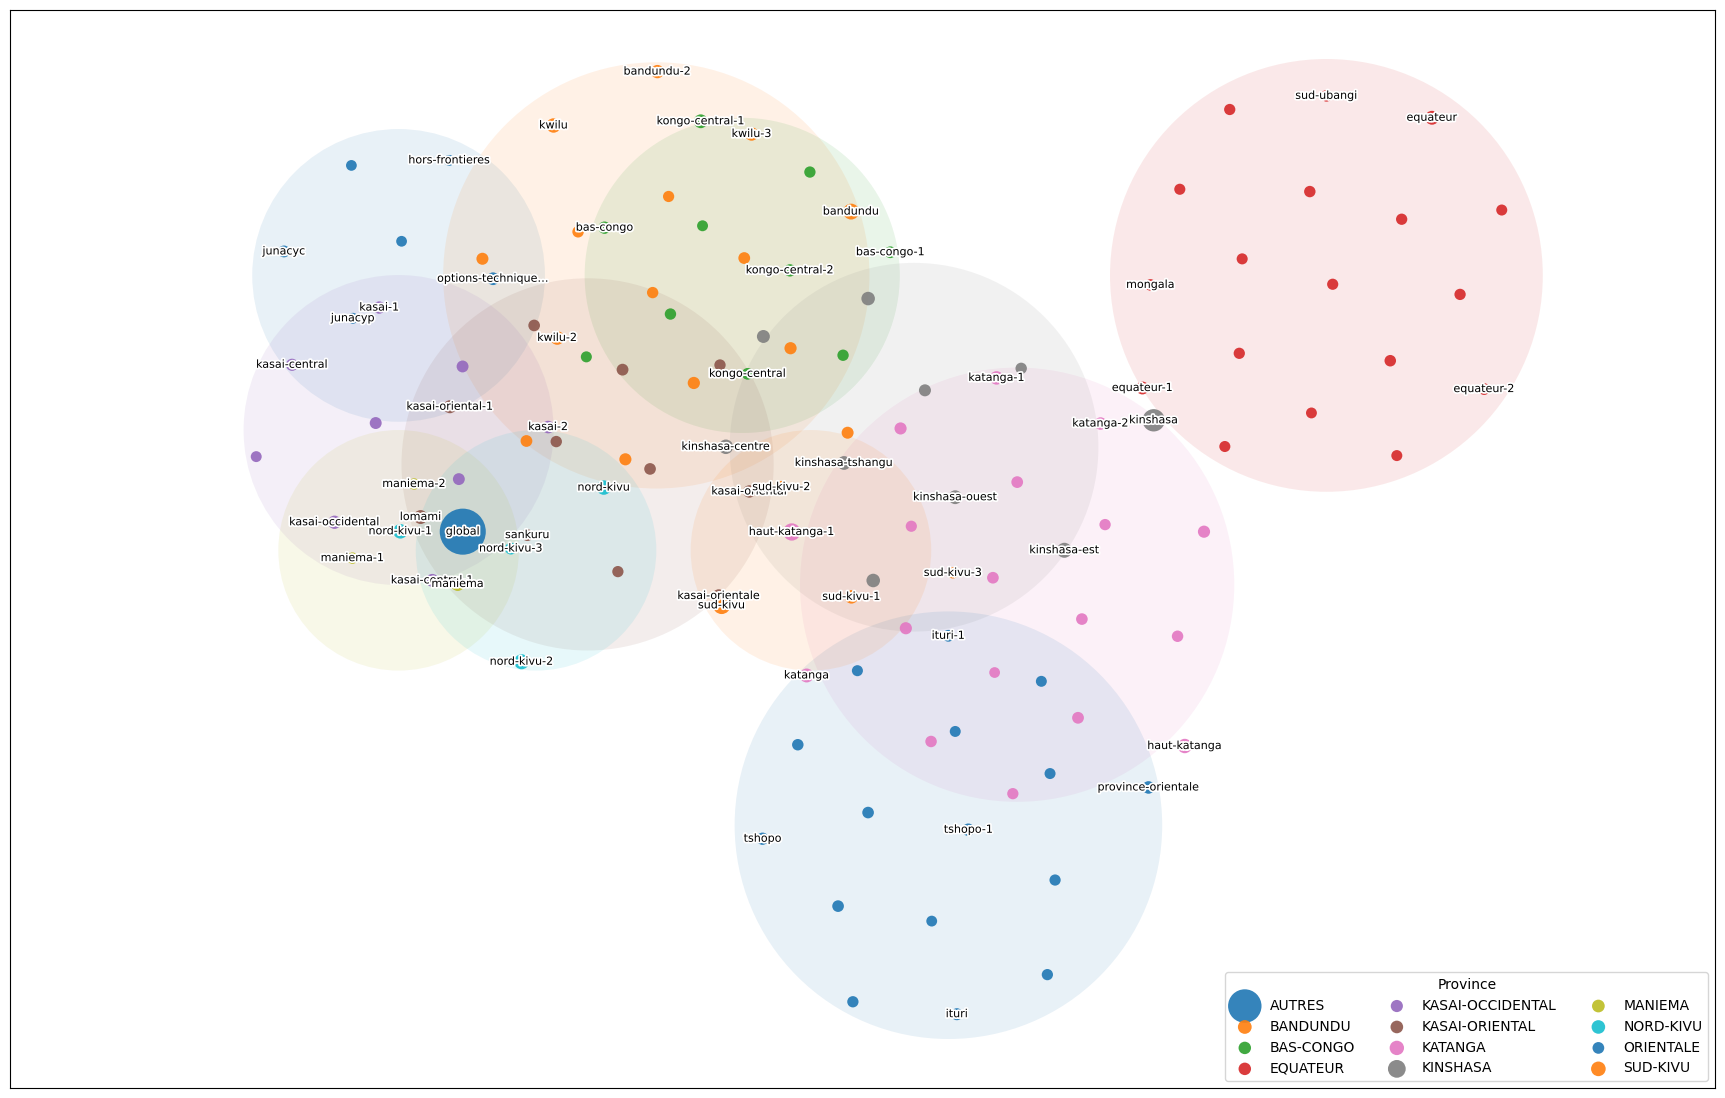

In [16]:
plot_region_clusters_by_province_readable(
    df, label_top_k=5, min_count_for_dot=2, base_padding=0.5, figsize=(22, 14)
)

# Year

In [ ]:
table = (
    df["year"]
    .value_counts()  # counts by frequency
    .rename_axis("Value")  # name the index
    .reset_index(name="Count")  # make it a DataFrame
    .sort_values("Value")  # sort alphabetically
    .reset_index(drop=True)  # clean row index
)

table

,Value,Count
0,2008,183051
1,2009,256209
2,2010,280484
3,2011,323867
4,2012,322043
5,2013,270742
6,2014,330042
7,2015,729980
8,2016,387432
9,2017,402320


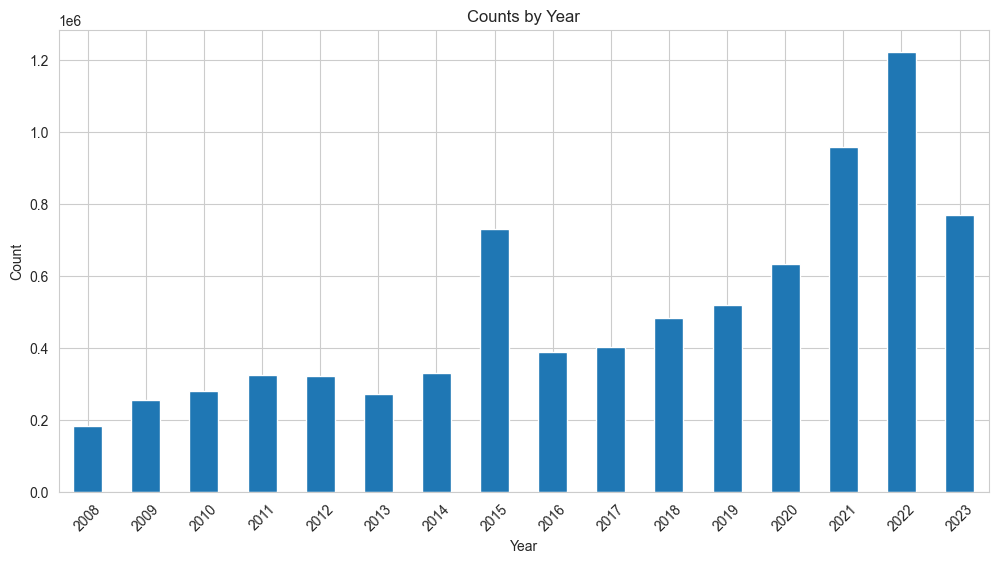

In [ ]:
table.plot(x="Value", y="Count", kind="bar", figsize=(12, 6), legend=False)

plt.xlabel("Year")
plt.ylabel("Count")
plt.title("Counts by Year")
plt.xticks(rotation=45)  # rotate x labels for readability
plt.show()

In [21]:
def build_parent_year_tables(
    regions: pd.Series, years: pd.Series, mapper: RegionMapper
) -> Dict[str, pd.DataFrame]:
    """
    Returns { PARENT -> DataFrame[year, count] } where count is the number of rows
    in that parent for each year (all subregions summed).
    """
    r = regions.astype(str).str.strip().str.lower()
    pd.to_numeric(years, errors="coerce").dropna().astype(int)
    # align after coercion
    df_regions = pd.DataFrame({"region": r, "year": years}).dropna(subset=["year"])
    df_regions["year"] = pd.to_numeric(df_regions["year"], errors="coerce").astype(
        "Int64"
    )
    df_regions = df_regions.dropna(subset=["year"])
    df_regions["year"] = df_regions["year"].astype(int)

    # Map to parent provinces via RegionMapper
    df_regions["parent"] = mapper.map(df_regions["region"])

    # Compute global year range so every parent gets the same y-axis domain
    if df_regions.empty:
        return {}
    year_min, year_max = df_regions["year"].min(), df_regions["year"].max()
    full_year_index = pd.Index(range(year_min, year_max + 1), name="year")

    # Group and build individual parent tables with missing years filled as 0
    g = df_regions.groupby(["parent", "year"]).size().rename("count").reset_index()
    tables: Dict[str, pd.DataFrame] = {}
    for parent, gp in g.groupby("parent"):
        gp = (
            gp.set_index("year")
            .reindex(full_year_index, fill_value=0)
            .rename_axis("year")
            .reset_index()[["year", "count"]]
        )
        tables[parent] = gp.sort_values("year").reset_index(drop=True)
    return tables


def plot_all_parents_by_year_grid(
    regions: pd.Series, years: pd.Series, mapper: RegionMapper, per_row: int = 4
):
    """
    Plot horizontal bar charts of yearly counts (summing all subregions) for each parent
    from RegionMapper.get_provinces(), arranged as a grid with `per_row` columns.
    """
    tables = build_parent_year_tables(regions, years, mapper)
    parents = [
        p.upper() for p in mapper.get_provinces()
    ]  # keep your canonical ordering
    n = len(parents)
    rows = math.ceil(n / per_row)

    fig_w = 6 * per_row
    fig_h = max(4.8 * rows, 3.5)
    fig, axes = plt.subplots(rows, per_row, figsize=(fig_w, fig_h))
    if rows == 1 and per_row == 1:
        axes = [[axes]]
    elif rows == 1:
        axes = [axes]
    elif per_row == 1:
        axes = [[ax] for ax in axes]

    for i, parent in enumerate(parents):
        r, c = divmod(i, per_row)
        ax = axes[r][c]

        dfp = tables.get(parent)
        if dfp is None or dfp.empty:
            ax.set_title(parent)
            ax.text(0.5, 0.5, "No data", ha="center", va="center")
            ax.set_axis_off()
            continue

        # Horizontal bars: y = year (string for tidy ticks), x = count
        ylabels = dfp["year"].astype(str)
        ax.barh(ylabels, dfp["count"])
        ax.set_title(parent)
        ax.set_xlabel("Count")
        ax.set_ylabel("Year")
        ax.invert_yaxis()  # most recent year at top if desired; remove if you prefer ascending top->bottom

        # compact y tick labels
        for label in ax.get_yticklabels():
            label.set_fontsize(8)

    # Turn off any unused axes
    total_axes = rows * per_row
    for j in range(n, total_axes):
        r, c = divmod(j, per_row)
        axes[r][c].set_axis_off()

    plt.tight_layout()
    plt.show()

2025-10-05 23:15:29,930 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-10-05 23:15:29,966 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-10-05 23:15:30,223 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-10-05 23:15:30,265 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-10-05 23:15:30,

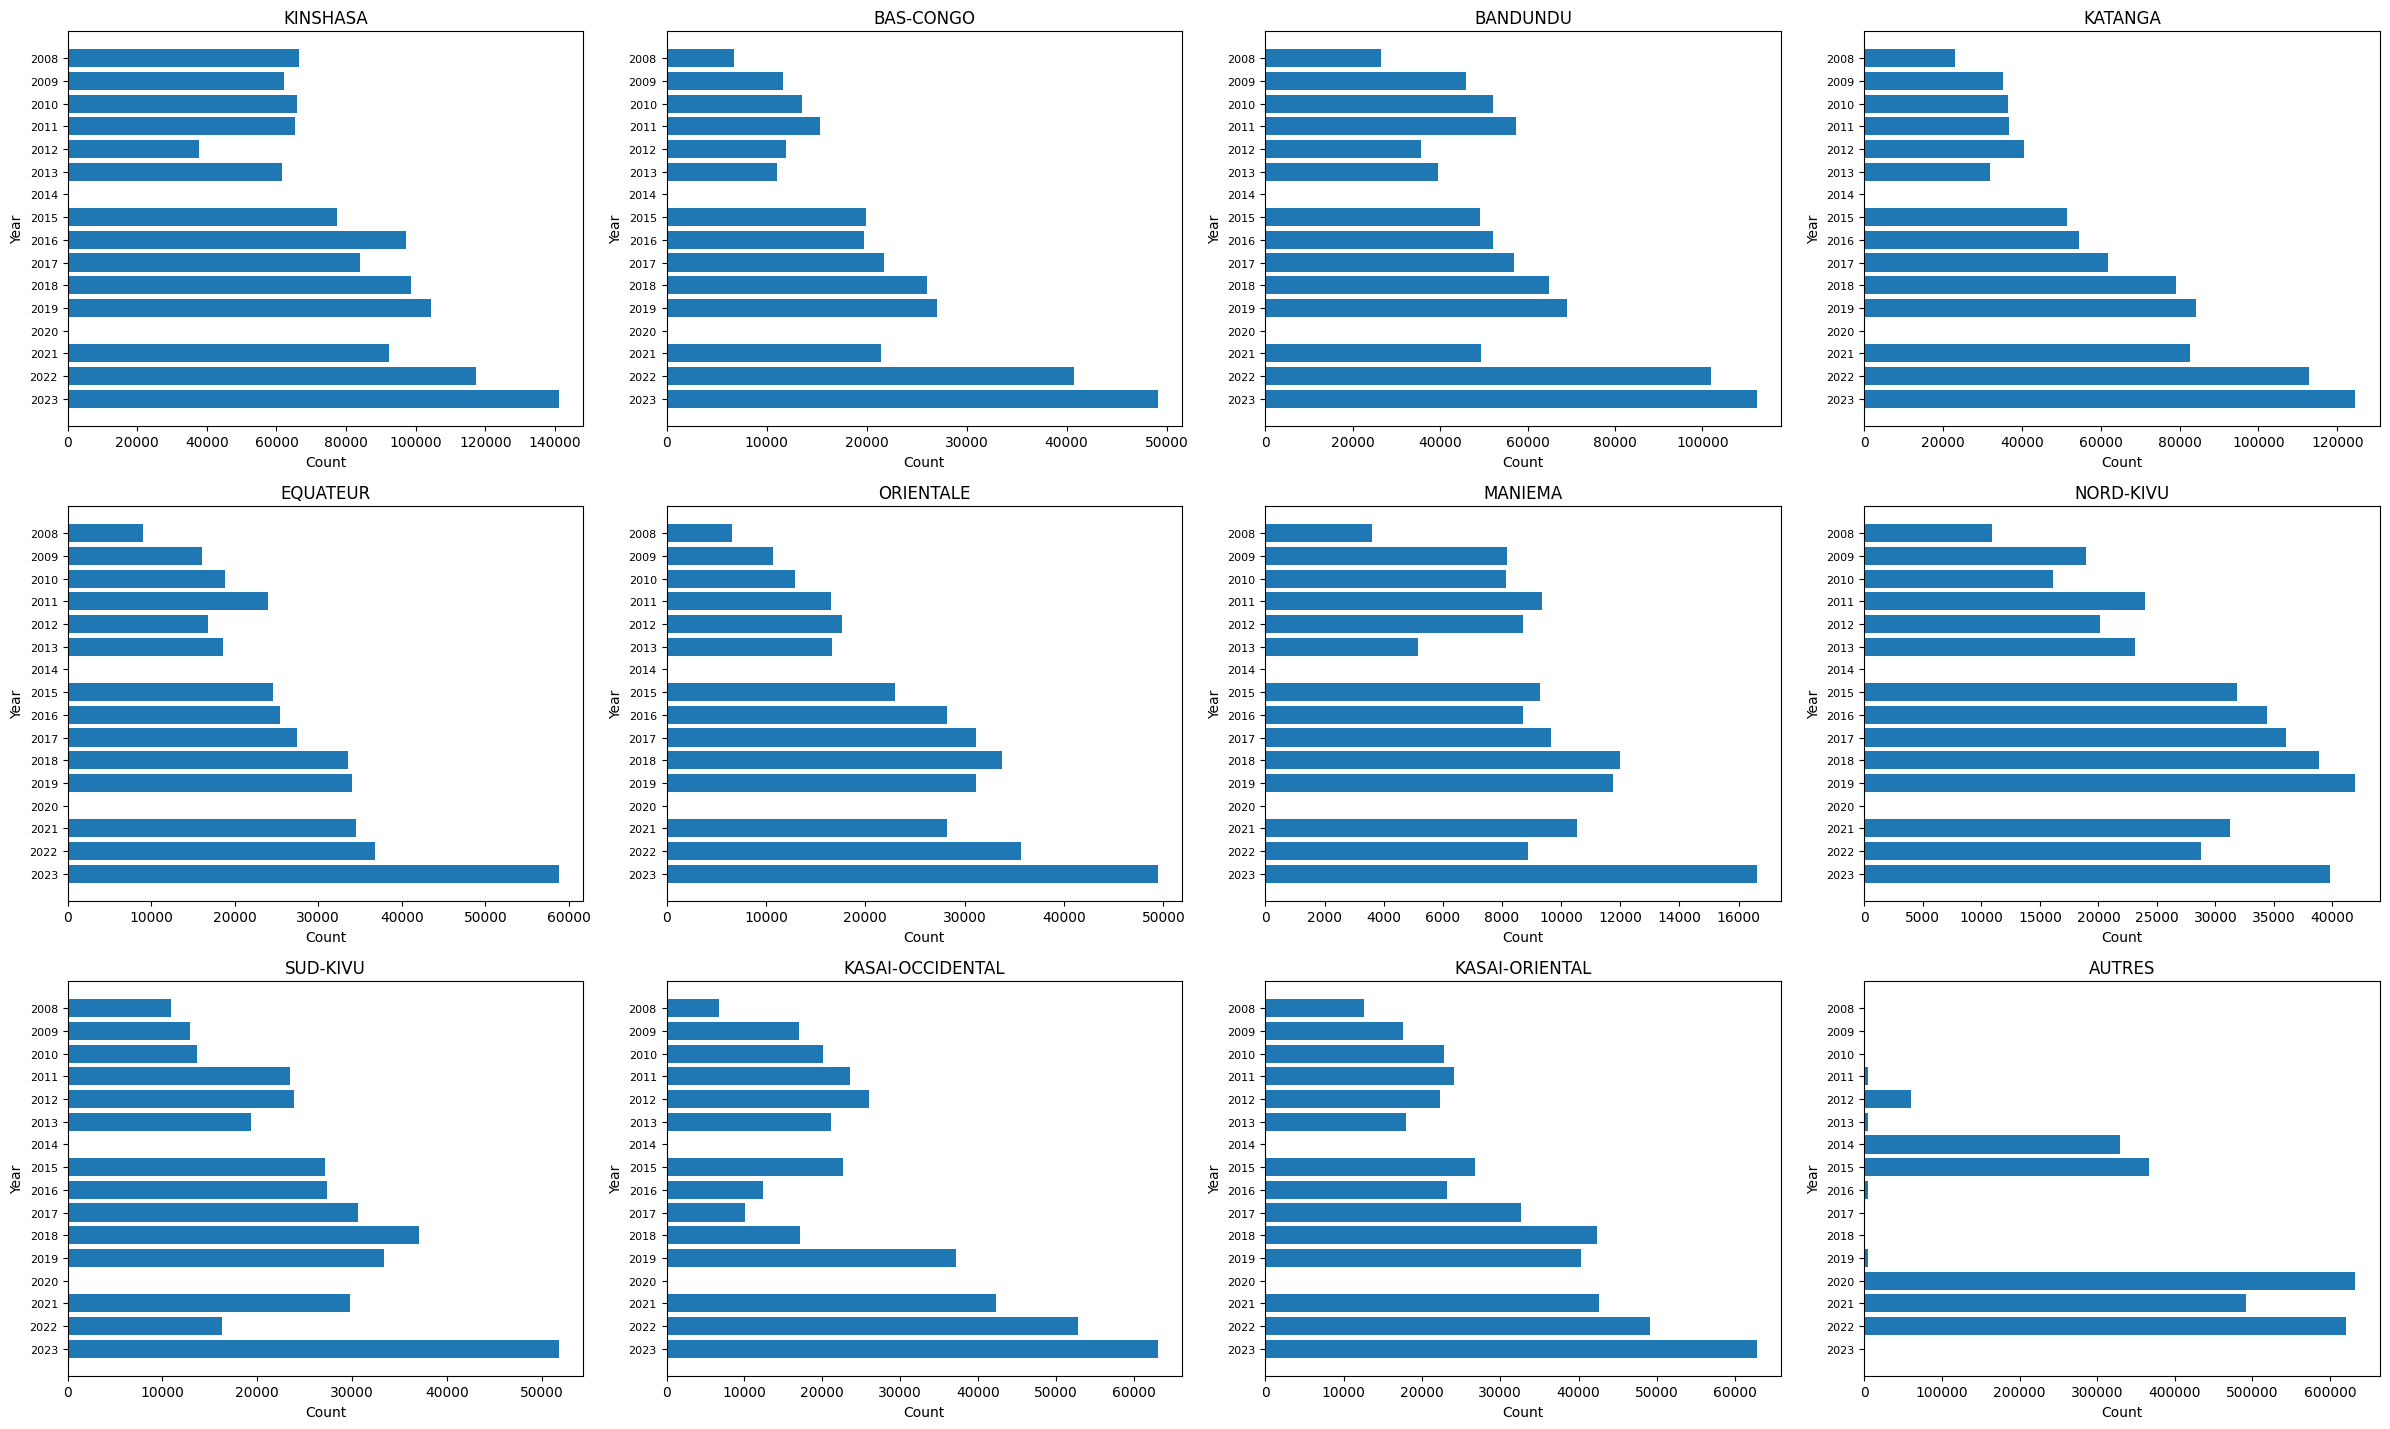

In [22]:
plot_all_parents_by_year_grid(df["region"], df["year"], RegionMapper(), per_row=4)